In [1]:
from dataset import ImageDataset, load_dataset, train_val_split, data_augmentation
from model import CNN, CNNWithNAL
import torch
from sklearn.metrics import accuracy_score
import pickle

torch.cuda.empty_cache()

# CIFAR
## Load dataset

In [2]:
training_data, training_labels, testing_data, testing_labels = load_dataset('datasets/CIFAR.npz')

# Visualisation

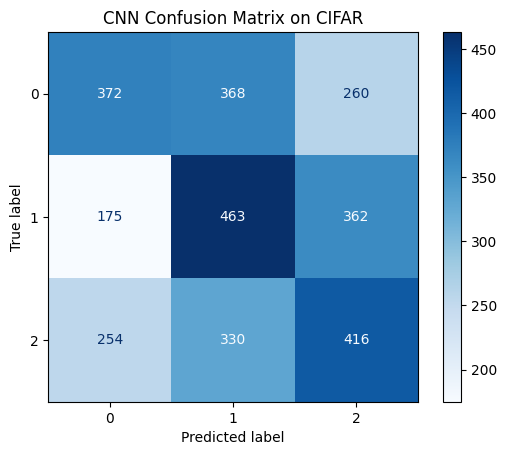

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
with open('results/cnn_CIFAR_pred_results.pkl', 'rb') as f:
    cnn_pred_results_CIFAR = pickle.load(f)
y_true = cnn_pred_results_CIFAR[0][0]
y_pred = cnn_pred_results_CIFAR[0][1]
cm = confusion_matrix(y_true, y_pred)
confusion_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
confusion_disp.plot(cmap=plt.cm.Blues)
plt.title('CNN Confusion Matrix on CIFAR')
plt.show()